## This notebook is to fine-tune existing Hugging face models for the summarisations task.

### Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

In [2]:
import os
import re
import nltk
import torch
import datasets
import numpy as np
import pandas as pd
from rouge import Rouge
import matplotlib.pyplot as plt
from datasets import DatasetDict
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,

)
from huggingface_hub import notebook_login


/Users/a81081529/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print("Using device:", device)

Using device: mps


## Importing and creating dataset
- Dataset is a Kaggle Article summarisation dataset: https://www.kaggle.com/datasets/sunnysai12345/news-summary/data?select=news_summary_more.csv

In [4]:
df = pd.read_csv("news_summary.csv", encoding='iso-8859-1')

In [5]:
df

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...
...,...,...,...,...,...,...
4509,Mansha Mahajan,"24 Feb 2017,Friday",Rasna seeking ?250 cr revenue from snack categ...,http://indiatoday.intoday.in/story/rasna-eyes-...,Fruit juice concentrate maker Rasna is eyeing ...,"Mumbai, Feb 23 (PTI) Fruit juice concentrate m..."
4510,Dishant Sharma,"03 Aug 2017,Thursday",Sachin attends Rajya Sabha after questions on ...,http://indiatoday.intoday.in/story/sachin-tend...,Former Indian cricketer Sachin Tendulkar atten...,Former cricketer Sachin Tendulkar was spotted ...
4511,Tanya Dhingra,"03 Aug 2017,Thursday",Shouldn't rob their childhood: Aamir on kids r...,http://www.hindustantimes.com/bollywood/secret...,"Aamir Khan, while talking about reality shows ...","Aamir Khan, whose last film Dangal told the st..."
4512,Pragya Swastik,"07 Dec 2016,Wednesday","Asha Bhosle gets ?53,000 power bill for unused...",http://indiatoday.intoday.in/story/singer-asha...,The Maharashtra government has initiated an in...,Maharahstra Power Minister Chandrashekhar Bawa...


In [6]:
cnt = 0
for text in df['ctext']:
  if isinstance(text, float):
    cnt += 1
print(cnt)

118


### Dropping the null values in the summary column

In [7]:
df = df.dropna()

### understanding the sequence lenght of the dataset to initate the model accordingly

In [8]:
max_headlines_words = max([len(list(headline.split(" "))) for headline in df['headlines']])
max_text_words = max([len(list(text.split(" "))) for text in df['text']])
max_ctext_words = max([len(list(ctexts.split(" "))) for ctexts in df['ctext']])

print(max_headlines_words)
print(max_text_words)
print(max_ctext_words)

14
62
12201


In [9]:
complete_dataset = pd.DataFrame()
complete_dataset['text'] = df['ctext']
complete_dataset['summary'] = df['text']
complete_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4396 entries, 0 to 4513
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     4396 non-null   object
 1   summary  4396 non-null   object
dtypes: object(2)
memory usage: 103.0+ KB


In [10]:
complete_dataset.head()

,text,summary
0,The Daman and Diu administration on Wednesday ...,The Administration of Union Territory Daman an...
1,"From her special numbers to TV?appearances, Bo...",Malaika Arora slammed an Instagram user who tr...
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Mumbai and other Indian cities are t...,Hotels in Maharashtra will train their staff t...


## Data Cleaning

In [11]:
nltk.data.path.append('working/nltk_data')

# Download the necessary NLTK data
nltk.download('wordnet', download_dir='working/nltk_data')
nltk.download('omw-1.4', download_dir='working/nltk_data')
nltk.download('punkt', download_dir='working/nltk_data')


[nltk_data] Downloading package wordnet to working/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to working/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to working/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
import zipfile
import os

nltk_data_dir = 'working/nltk_data/corpora'

# Extract the wordnet zip file
with zipfile.ZipFile(os.path.join(nltk_data_dir, 'wordnet.zip'), 'r') as zip_ref:
    zip_ref.extractall(os.path.join(nltk_data_dir))

# Extract the omw-1.4 zip file
with zipfile.ZipFile(os.path.join(nltk_data_dir, 'omw-1.4.zip'), 'r') as zip_ref:
    zip_ref.extractall(os.path.join(nltk_data_dir))

- Cleans logs/emails/text documents

- Removes noise and artifacts

- Replaces structured patterns with tags

- Keeps URLs minimal

- Lemmatizes for better NLP model performance

In [13]:
lemmatizer = WordNetLemmatizer()


def data_cleaning(column, column_name=""):
    data = []
    for row in column:
        
        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        #row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        row=re.sub(r"[<>()|&©ø\[\]\'\;~*]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        tokens = word_tokenize(row)
        lemmatized_row = ' '.join([lemmatizer.lemmatize(token) for token in tokens])
        data.append(lemmatized_row)

    data = pd.DataFrame({column_name: data})
    
    return data

In [14]:
brief_cleaning1 = data_cleaning(complete_dataset['text'], column_name='text')
brief_cleaning2 = data_cleaning(complete_dataset['summary'], column_name='summary')

In [15]:
brief_cleaning1['text'][0]

'the daman and diu administration on wednesday withdrew circular that asked woman staff to tie rakhis on male colleague after the order triggered backlash from employee and wa ripped apart on social media.the union territory ? s administration wa forced to retreat within 24 hour of issuing the circular that made it compulsory for it staff to celebrate rakshabandhan at workplace . ? it ha been decided to celebrate the festival of rakshabandhan on august in this connection , all offices/ department shall remain open and celebrate the festival collectively at suitable time wherein all the lady staff shall tie rakhis to their colleague , ? the order , issued on august by gurpreet singh , deputy secretary personnel had said.to ensure that no one skipped office , an attendance report wa to be sent to the government the next evening.the two notification one mandating the celebration of rakshabandhan left and the other withdrawing the mandate right were issued by the daman and diu administrati

In [16]:
brief_cleaning2['summary'][0]

'the administration of union territory daman and diu ha revoked it order that made it compulsory for woman to tie rakhis to their male colleague on the occasion of rakshabandhan on august the administration wa forced to withdraw the decision within 24 hour of issuing the circular after it received flak from employee and wa slammed on social medium .'

In [17]:
cleaned_complete_dataset = pd.DataFrame()
cleaned_complete_dataset['text'] = brief_cleaning1['text']
cleaned_complete_dataset['summary'] = brief_cleaning2['summary']
cleaned_complete_dataset.head()

,text,summary
0,the daman and diu administration on wednesday ...,the administration of union territory daman an...
1,"from her special number to tv ? appearance , b...",malaika arora slammed an instagram user who tr...
2,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...
3,lashkar-e-taiba kashmir commander abu dujana w...,"lashkar-e-taiba kashmir commander abu dujana ,..."
4,hotel in mumbai and other indian city are to t...,hotel in maharashtra will train their staff to...


In [18]:
text_count = []
summary_count = []

for sent in cleaned_complete_dataset['text']:
    text_count.append(len(sent.split()))
for sent in cleaned_complete_dataset['summary']:
    summary_count.append(len(sent.split()))

In [19]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

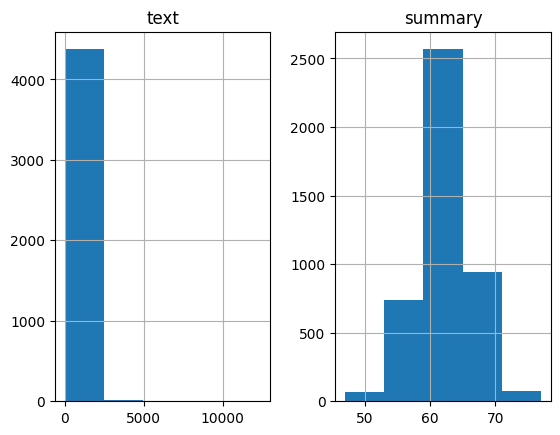

In [20]:
graph_df.hist(bins = 5)
plt.show()

In [21]:
max_text_len = 2500
max_summary_len = 70
print(max_text_len)
print(max_summary_len)

2500
70


In [22]:
cleaned_text =np.array(cleaned_complete_dataset['text'])
cleaned_summary=np.array(cleaned_complete_dataset['summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
cleaned_complete_dataset=pd.DataFrame({'text':short_text,'summary':short_summary})

In [23]:
cleaned_complete_dataset.head()

,text,summary
0,the daman and diu administration on wednesday ...,the administration of union territory daman an...
1,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...
2,hotel in mumbai and other indian city are to t...,hotel in maharashtra will train their staff to...
3,an alleged suspect in kidnapping case wa found...,a 32-year-old man on wednesday wa found hangin...
4,"in an interesting ruling , the delhi high cour...",the delhi high court reduced the compensation ...


In [24]:
cleaned_complete_dataset.rename(columns={"text": "news"}, inplace = True)

## Creating Model

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
# Converting the pandas dataset to huggingface dataset
# first split the train and test set
train_df, test_df = train_test_split(cleaned_complete_dataset, test_size=0.1, shuffle=True)
print("train and val shape:", train_df.shape, "test shape:",test_df.shape)
# save for every model inference
global_train_df = train_df
global_test_df = test_df
train_df = datasets.Dataset.from_pandas(train_df)
train_df = train_df.remove_columns(["__index_level_0__"])
# split train into train and val
train_df = train_df.train_test_split(test_size=0.2, shuffle=True) # split train and test
train_df["train"][0]

train and val shape: (3867, 2) test shape: (430, 2)


{'news': 'veteran actor mithun chakraborty say stand-up comedian kapil sharma is one of the biggest talent he ha seen in his career the 67-year-old actor would be seen in krushna abhishek ? s new show the drama company krushna ? s comedy show will air on the same channel , sony , which ha the kapil sharma show.krushna and kapil are often pitched a competitor asked about the competition between them , mithun , in an interview say , ? how can it be competition a it is on the same channel will producer wish that his one film should perform badly ? have no idea about it referring to competition between the two comedian on color channel but feel no one should compare kapil is one of the biggest talent have seen in my film career , he is very talented his show is huge , it will take time for krushna ? s show to reach there . ? mithun , who wa regular on tv with dance reality show dance india dance , took sudden break from the small screen due to health issue the actor , however , say the com

In [27]:
# Fitting into dataset dict
train_val_test_dataset = DatasetDict({
    'train': train_df["train"],
    'val': train_df['test']})

print(type(train_val_test_dataset))
train_val_test_dataset

<class 'datasets.dataset_dict.DatasetDict'>


DatasetDict({
    train: Dataset({
        features: ['news', 'summary'],
        num_rows: 3093
    })
    val: Dataset({
        features: ['news', 'summary'],
        num_rows: 774
    })
})

### using the google t5 model for fine-tuning using the datasset

In [28]:
model_name = 'lucadiliello/bart-small'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [29]:
def prepare_dataset(data):
    inputs = data["news"]
    model_inputs = tokenizer(inputs, max_length=2000, truncation=True)
    labels = tokenizer(text_target=data["summary"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [30]:
tokenized_data = train_val_test_dataset.map(prepare_dataset, batched=True)

Map: 100%|██████████| 774/774 [00:00<00:00, 3426.81 examples/s]


In [31]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['news', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3093
    })
    val: Dataset({
        features: ['news', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 774
    })
})

In [32]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)

In [33]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = Rouge().get_scores(decoded_preds, decoded_labels, avg=True, ignore_empty=True)

    # prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    # result["gen_len"] = np.mean(prediction_lens)

    return result

In [34]:
# prepare the model
T5model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels will be overwritten to 2.


In [35]:
# # set up hyper-parameters
# training_args = Seq2SeqTrainingArguments(
#     output_dir="t5-news",
#     evaluation_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,
#     weight_decay=0.01,
#     save_total_limit=2,
#     num_train_epochs=4,
#     predict_with_generate=True,
#     fp16=True,
#     report_to="none"
#     # push_to_hub=True,
# )

training_args = Seq2SeqTrainingArguments(
    output_dir="bart-news",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    weight_decay=0.01,
    num_train_epochs=4,
    predict_with_generate=True)


In [36]:
# setup trainer
trainer = Seq2SeqTrainer(
    model = T5model,
    args = training_args,
    train_dataset = tokenized_data["train"],
    eval_dataset = tokenized_data["val"],
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics
)

/var/folders/9c/qv171l592lv98_dd9fb2s5g40000gq/T/ipykernel_95681/3171048545.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [37]:
sample = tokenized_data["train"][0]
print("Input IDs:", sample["input_ids"])
print("Labels:", sample["labels"])
print("Label Length:", len(sample["labels"]))
print("Num ignored labels:", sample["labels"].count(-100))


Input IDs: [0, 548, 1334, 260, 2701, 475, 3432, 879, 1855, 677, 14191, 2723, 219, 224, 1413, 12, 658, 10688, 449, 1115, 718, 1481, 15277, 16, 65, 9, 5, 934, 2959, 37, 2489, 450, 11, 39, 756, 5, 5545, 12, 180, 12, 279, 2701, 74, 28, 450, 11, 449, 29349, 2133, 4091, 12724, 700, 330, 17487, 579, 92, 311, 5, 4149, 138, 449, 29349, 2133, 17487, 579, 5313, 311, 40, 935, 15, 5, 276, 4238, 2156, 579, 6119, 2156, 61, 2489, 5, 449, 1115, 718, 1481, 15277, 311, 4, 330, 29349, 2133, 8, 449, 1115, 718, 32, 747, 8050, 10, 11439, 553, 59, 5, 1465, 227, 106, 2156, 475, 3432, 879, 2156, 11, 41, 1194, 224, 2156, 17487, 141, 64, 24, 28, 1465, 10, 24, 16, 15, 5, 276, 4238, 40, 3436, 2813, 14, 39, 65, 822, 197, 3008, 7340, 17487, 33, 117, 1114, 59, 24, 5056, 7, 1465, 227, 5, 80, 10688, 15, 3195, 4238, 53, 619, 117, 65, 197, 8933, 449, 1115, 718, 16, 65, 9, 5, 934, 2959, 33, 450, 11, 127, 822, 756, 2156, 37, 16, 182, 5918, 39, 311, 16, 1307, 2156, 24, 40, 185, 86, 13, 449, 29349, 2133, 17487, 579, 311, 7, 1

In [38]:
trainer.train()

/Users/a81081529/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,2.842400
1000,2.581900
1500,2.445400
2000,2.305500
2500,2.236900
3000,2.181900
3500,2.142400
4000,2.101100
4500,2.077200
5000,2.017900


/Users/a81081529/.pyenv/versions/3.10.11/lib/python3.10/site-packages/transformers/modeling_utils.py:3685: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/Users/a81081529/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/a81081529/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/a81081529/.pyenv/versions/3.10.11/lib/python3.10/site

TrainOutput(global_step=6188, training_loss=2.2393215847693493, metrics={'train_runtime': 45846.6866, 'train_samples_per_second': 0.27, 'train_steps_per_second': 0.135, 'total_flos': 1860493472624640.0, 'train_loss': 2.2393215847693493, 'epoch': 4.0})

In [39]:
T5model.save_pretrained("working-bart/bart-model")
tokenizer.save_pretrained("working-bart/tokenizer")

('working-bart/tokenizer/tokenizer_config.json',
 'working-bart/tokenizer/special_tokens_map.json',
 'working-bart/tokenizer/vocab.json',
 'working-bart/tokenizer/merges.txt',
 'working-bart/tokenizer/added_tokens.json',
 'working-bart/tokenizer/tokenizer.json')

## testing the fine-tuned model

In [40]:
tokenizer = AutoTokenizer.from_pretrained("working-bart/tokenizer", local_file_only=True)

In [41]:
from transformers import pipeline

In [42]:
test_dataset = DatasetDict({
    'test': test_df})

print(type(test_dataset))
test_dataset

<class 'datasets.dataset_dict.DatasetDict'>


DatasetDict({
    test:                                                    news  \
    2887  a shocking video of miscreant attacking homele...   
    2072  the bhandup police arrested 27-year-old man on...   
    1843  do you remember uber ? no , not the cab but th...   
    1602  the dangal is over victory ha been achieved ac...   
    189   new delhi , jul 31 pti a many a 43 per cent of...   
    ...                                                 ...   
    3443  the supreme court today said that the lokpal b...   
    3587  mumbai , apr 16 pti actress alia bhatt , who p...   
    252   caput , one of the uk ? s largest outsourcing ...   
    3959  sanjay dutt , who is currently busy shooting f...   
    1907  former world no tennis player and ex-coach of ...   
    
                                                    summary  
    2887  a video of several drunk men attacking 50-year...  
    2072  a 27-year-old man wa arrested in bhandup by th...  
    1843  uber ceo travis kalanic

In [43]:
test_dataset['test']

,news,summary
2887,a shocking video of miscreant attacking homele...,a video of several drunk men attacking 50-year...
2072,the bhandup police arrested 27-year-old man on...,a 27-year-old man wa arrested in bhandup by th...
1843,"do you remember uber ? no , not the cab but th...",uber ceo travis kalanick ha announced scholars...
1602,the dangal is over victory ha been achieved ac...,aamir khan-starrer dangal ha become the highes...
189,"new delhi , jul 31 pti a many a 43 per cent of...",labour minister bandaru dattatreya ha said tha...
...,...,...
3443,the supreme court today said that the lokpal b...,"hearing petition filed by ngo common cause , t..."
3587,"mumbai , apr 16 pti actress alia bhatt , who p...",actress alia bhatt ha said that the film udta ...
252,"caput , one of the uk ? s largest outsourcing ...","caput , one of the uk ? s largest outsourcing ..."
3959,"sanjay dutt , who is currently busy shooting f...",sanjay dutt ha suffered hairline rib fracture ...


In [44]:
pipe = pipeline("summarization", model="bart-news/checkpoint-6188", tokenizer=tokenizer, device=device)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels will be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels will be overwritten to 2.
Device set to use mps


In [45]:
pipe([brief_cleaning1['text'][0]])

[{'summary_text': 'the daman and diu administration on wednesday withdrew circular that asked woman staff to tie rakhis on male colleague after the order triggered backlash from employee and wa ripped apart on social media the union territory administration wa forced to retreat within 24 hour of issuing the circular that made it compulsory for it staff to celebrate rakshabandhan at workplace .'}]

In [46]:
temp=pipe(["China have won the first gold medal of Paris 2024 Olympics. Chinese shooters Sheng Lihao and Huang Yuting defeated South Korea's Keum Ji-hyeon and Park Ha-jun 16-12 to bag gold medal in 10m Air Rifle mixed team event. Kazakhstan bagged bronze medal in the event, while Germany finished fourth. Indian shooters Ramita and Arjun Babuta finished sixth."])

Your max_length is set to 128, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


In [47]:
len(temp[0]['summary_text'].split(" "))

40

In [48]:
test_df_new=pd.DataFrame(["There it stands, behind a glass case on the rotating platform in the centre of the Egmore Museum Bronze Gallery. Perfectly proportioned, rhythmic curves on one side, and graceful, well-defined lines on the other. Is the Ardhanarisvara supposed to represent contrast between man and woman? Or is it supposed to be a representation of equality? The answer lies a little deeper, in the queer communities that worship Ardhanarisvara as an icon of liminal sexuality. The god is neither man nor woman, and falls on a spectrum in Hinduism that only a few mainstream characters can lay claim to. While dancers have interpreted and reinterpreted the idol (most popularly through compositions by Dikshitar and Sankaracharya) can classical dance claim understanding or exploration of the queer experience? Recently, dance has expanded its perspectives on mythological content by spotlighting queer characters, and tapping into the several stories from our rich literary tradition that demonstrate a pre-colonial Indian perspective on the matter. Productions such as Harikrishnan’s ‘When Siva Kissed Vishnu’ and Himanshu Srivastava’s depiction of Shikhandi, use traditional choreography skills with a modern sensibility to treat the subject of the queer experience. Yet, it still feels like much of LGBTQ+ material is considered taboo amongst classical musicians and dancers. It is almost as if some self-appointed guardians of the art form see queerness as foreign to India, and specifically to dance and music. Does India have inherently queer performance traditions? A vast majority of geographical regions in India have indigenous trans communities with specific performance traditions, such as the jogappas of Karnataka. Some of these traditions are ancient and well incorporated into the cultural fabric of the region they represent, begging the question of whether the stigma around queerness is unique to the classical realm. To find an answer, we must journey back in time. In addition to numerous mythological stories, sociological texts such as the Kamasutra refer freely to homoerotic encounters. Similarly, we have evidence of trans performers in the royal courts of south India, often serving as interlocutors for professional dancing women. These figures were extremely important as they traversed around the palaces easily, moving from spaces restricted to women, into the private chambers of the king carrying with them exceptional musical and mimetic ability as well as sensitive information. To find visual representation of the LGBTQ+ community in sacred architecture is effortless. From Khajuraho in Madhya Pradesh to Odisha, all manner of queer social and sexual activities are depicted on our temple walls, with some sculptures boasting a history of 1000 years or more. The Madurai Meenakshi temple contains a beautiful sculpture of a figure with breasts, a beard and a moustache, considered by scholars to be a depiction of Brihanalla. The diversity in depicting queerness visually spans across geographical regions, cultures and media — including painting, sculpture, music and dance. Furthermore, literature seems to reflect the same type of diversity in perspectives. There has been much debate about whether Kshetrayya’s open love for his lord Muvvagopala has erotic undertones. Similarly, a close reading of the Tiruvaasagam reveals extremely detailed, romantic descriptions of Shiva, lending a queerness to the voice of Manickavasagar. While more conservative scholars dismiss these details as the author “impersonating” a woman as a literary device, the descriptions are so detailed that one is compelled to explore all the explanations for this style of writing."])

In [49]:
test_df_new.columns= ["text"]

In [50]:
test_df_new

,text
0,"There it stands, behind a glass case on the ro..."


In [51]:
cleaned_new_data = data_cleaning(test_df_new['text'], column_name='text')

In [52]:
pipe(cleaned_new_data['text'][0])

Token indices sequence length is longer than the specified maximum sequence length for this model (707 > 512). Running this sequence through the model will result in indexing errors


[{'summary_text': 'the art form of egmore museum in egmore , in the centre of the art form , is designed to portray the subject of the queer experience notably , dance ha expanded it perspective on mythological content by spotlighting queer character , and tapping into the several story from our rich literary tradition that demonstrate pre-colonial indian perspective .'}]